In [33]:
# for load the data
import pandas as pd
import numpy as np 

#for data visualisation
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
#from wordcloud import WordCloud,STOPWORDS

#for text cleaning
import re
import string
from nltk.corpus import stopwords,wordnet
#from nltk.stem import PorterStemmer
import nltk 
from nltk.stem import WordNetLemmatizer
#for tokenization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#for split the data into train & test
from sklearn.model_selection import train_test_split

#for model building
import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.layers import LSTM,Embedding,Dense, Flatten, Dropout , Bidirectional , Dropout,GlobalAveragePooling1D

#for model evaluation
from sklearn.metrics import classification_report,confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [34]:
data_train = pd.read_csv("/Users/revan/Downloads/congressional_tweet_training_data.csv")
data_test = pd.read_csv("/Users/revan/Downloads/congressional_tweet_test_data.csv")
data_train = df_train.fillna('')
data_test = data_test.fillna('')

In [35]:
data_train.head()

,favorite_count,full_text,hashtags,retweet_count,year,party_id
0,0,"b""RT @KUSINews: One of our longtime viewers wa...",KUSI,10,2017.0,R
1,258,"b""Today I'm urging the @CDCgov to immediately ...",Coronavirus,111,2020.0,R
2,0,"b'Tomorrow, #MO03 seniors graduate from Calvar...",MO03,2,2014.0,R
3,9,b'Congrats to #TeamUSA and Canton Native @JGre...,TeamUSA WorldJuniors,3,2017.0,R
4,3,b'Pleased to support @amergateways at their Ju...,ImmigrantHeritageMonth,3,2019.0,D


In [36]:
data_test.head()

,Id,favorite_count,full_text,hashtags,retweet_count,year,party
0,0,70,b'#TaxReform improved the playing field for Am...,TaxReform,13,2018.0,D
1,1,27,"b'This #NativeWomensEqualPay Day, we recommit ...",NativeWomensEqualPay,11,,D
2,2,49,"b""\xe2\x80\x9cI became convinced that our gene...",MeToo ShatteringTheSilence,24,2017.0,D
3,3,14,"b'During #NationalAdoptionMonth, we honor the ...",NationalAdoptionMonth,2,2019.0,D
4,4,13,b'Happy #AirborneDay to our @USArmy paratroope...,AirborneDay AirborneAllTheWay,7,2018.0,D


In [37]:
print('shape train dataframe:',data_train.shape)
print('shape test dataframe:',data_test.shape)

shape train dataframe: (592803, 6)
shape test dataframe: (265000, 7)


In [38]:
# print sum of null values for train and test dataframe
print("null values for train data : ")
print(data_train.isna().sum())
print("null values for test data : ")
print(data_test.isna().sum())

null values for train data : 
favorite_count    0
full_text         0
hashtags          0
retweet_count     0
year              0
party_id          0
dtype: int64
null values for test data : 
Id                0
favorite_count    0
full_text         0
hashtags          0
retweet_count     0
year              0
party             0
dtype: int64


D    324202
R    268601
Name: party_id, dtype: int64
0 : 54.69 %
1 : 45.31 %


<AxesSubplot:xlabel='party_id', ylabel='count'>

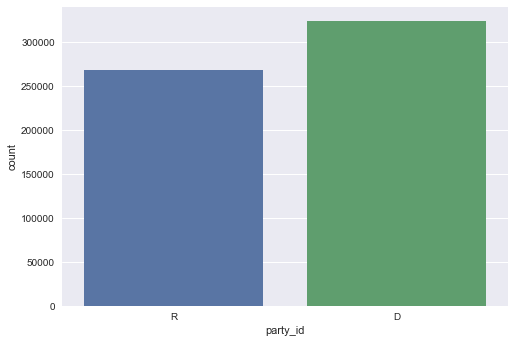

In [40]:
s=data_train.party_id.value_counts()
print(s)
print('0 :',round(s[0]/len(data_train)*100,2),'%')
print('1 :',round(s[1]/len(data_train)*100,2),'%')
sns.countplot(data_train['party_id'])

In [42]:
#define new column that contain the length of each text in the dataframe
data_train["text_length"] = data_train['full_text'].apply(lambda x:len(x.split()))
data_test["text_length"] = data_test['full_text'].apply(lambda x:len(x.split()))

In [43]:
print('the max length tweet for train data is:',data_train['text_length'].max()) 
print('the min length tweet for train data is:',data_train['text_length'].min())
print('the max length tweet for test data is:',data_test['text_length'].max()) 
print('the min length tweet for test data is:',data_test['text_length'].min())

the max length tweet for train data is: 85
the min length tweet for train data is: 1
the max length tweet for test data is: 64
the min length tweet for test data is: 1


<AxesSubplot:ylabel='Frequency'>

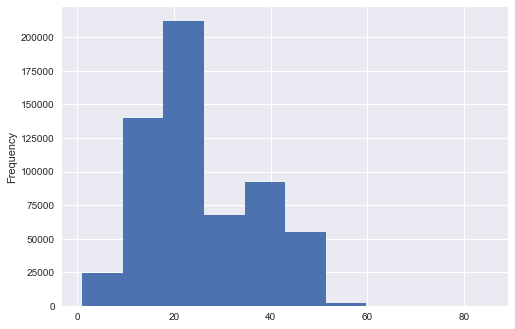

In [44]:
data_train['text_length'].plot.hist()

In [55]:
print(len(data_train[data_train.text_length<2]))
print(len(data_train[data_train.text_length>55]))

173
115


In [56]:
# delete all tweets that have Nbr words less then 4 and more then 25
#data_train = data_train[~(data_train.text_length<2)]
#data_train = data_train[~(data_train.text_length>25)]

In [60]:
def clean_text(data):
    # convert letters to lowercase
    data['clean_text']=data['full_text'].str.lower()
    #remove URLS
    data['clean_text'] = data['full_text'].apply(lambda elem:re.sub(r"http\S+", "", elem))
    #remove ponctuation
    data['clean_text'] = data['full_text'].apply(lambda elem:re.sub(r"[^\w\s]", "", elem))
    #remove 
    data['clean_text'] = data['full_text'].apply(lambda elem:re.sub(r'/n',"",elem))
    #remove degits
    data['clean_text'] = data['full_text'].apply(lambda elem:re.sub(r'\d+',"",elem))
    #remove multiple spaces
    data['clean_text'] = data['full_text'].apply(lambda elem:re.sub(r'\s+'," ",elem))
    #remove single caracter
    data['clean_text'] = data['full_text'].apply(lambda elem:re.sub(r'\s+[a-zA-Z]\s+'," ",elem))
    return data

In [61]:
data_train=clean_text(data_train)
data_test=clean_text(data_test)

In [62]:
def remove_Stopwords(text):
    stopW=stopwords.words('english') #get the english stopwords
    return " ".join([i for i in text.split() if i not in stopW])

data_train['clean_text']=data_train['clean_text'].apply(lambda x:remove_Stopwords(x))

In [63]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(text):
    # 1. Init Lemmatizer
    lemmatizer = WordNetLemmatizer()
    # 2. Lemmatize text with the appropriate POS tag
    return " ".join([lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in text.split()])


#Apply lemmatizer to each row in the dataframe
data_train['clean_text'] = data_train['clean_text'].apply(lambda x:lemmatize(x) )

In [68]:
max_features = 100000
#Tensorflow Tokenizer
tokenizer = Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(data_train['clean_text'].values)
X = tokenizer.texts_to_sequences(data_train['clean_text'].values)
X = pad_sequences(X,padding='post')

In [65]:
def linearscv(df):    
    clean_text = df['clean_text'].tolist()
    vectorizer1 = CountVectorizer(ngram_range=(1,1), lowercase= True)
    cv1 = vectorizer1.fit_transform(clean_text)
    tfidf1 = TfidfVectorizer(ngram_range=(1,1), lowercase= True)
    tfidf2 = TfidfVectorizer(ngram_range=(1,2), lowercase= True)
    tfidf3 = TfidfVectorizer(ngram_range=(1,3), lowercase= True)
    tf1 = tfidf1.fit_transform(clean_text)
    tf2 = tfidf2.fit_transform(clean_text)
    tf3 = tfidf3.fit_transform(clean_text)
    return (cv1, tf1, tf2, tf3)

,Id,party
0,0,D
1,1,D
2,2,D
3,3,D
4,4,D
...,...,...
95,95,D
96,96,D
97,97,D
98,98,D
